# Overview

This notebook will be used to unpack or convert any datasets


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gc

$$ $$

$$ $$

$$ $$

# 2023 taxi cab dataset

concatenate all months into one parquet file:

In [ ]:
import pandas as pd

all_dfs = []

for month in range(1, 13):
    parquet_path = f"2023 yellow taxi/trip parquets/yellow_tripdata_2023-{month:02d}.parquet"
    
    print(f"yellow_tripdata_2023-{month:02d}.parquet")
    df = pd.read_parquet(parquet_path)
    all_dfs.append(df)


# concatenate
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"Full concatenated shape: {full_df.shape}")

# Save as parquet
full_parquet_path = "2023 yellow taxi/trip parquests/yellow_tripdata_2023.parquet"
full_df.to_parquet(full_parquet_path, index=False)


In [3]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38310226 entries, 0 to 38310225
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

$$ $$

## Clean the data:

For the simulation, I will only be keeping the following columns:

- tpep_pickup_datetime
- tpep_dropoff_datetime
- trip_distance
- RatecodeID
- PULocationID
- DOLocationID
- congestion_surcharge
- airport_fee

$$ $$

I need to filter and removes with the following column values:

- tpep_pickup_datetime
  - invalid





In [3]:
import pandas as pd

In [4]:
df = pd.read_parquet("2023 yellow taxi/trip parquets/yellow_tripdata_2023.parquet")

### Combine airport_fee and Airport_fee columns under airport_fee

In [5]:
both_not_na = df[df["airport_fee"].notna() & df["Airport_fee"].notna()]

print(f"{len(both_not_na)} rows have notna airport_fee and Airport_fee")

0 rows have notna airport_fee and Airport_fee


In [6]:
df["airport_fee"] = df["airport_fee"].combine_first(df["Airport_fee"])
df = df.drop(columns=["Airport_fee"])

### Filter out pickup and dropoff times outside of 2023

In [7]:
start = pd.Timestamp("2023-01-01")
end   = pd.Timestamp("2024-01-01")

original_rows = df.shape[0]
df = df[(df['tpep_pickup_datetime'] >= start) & (df['tpep_dropoff_datetime'] < end)]
date_filtered_rows = df.shape[0]

print(f"{original_rows - date_filtered_rows} rows lost in time filtering")

626 rows lost in time filtering


$$ $$

### Filter out invalid distance measurements

keep trips where 0 < d < 100

In [8]:
num_zero = len(df[df['trip_distance'] <= 0])
num_over_100 = len(df[df['trip_distance'] > 100])

print(f"There are {num_zero} zero distance rows and {num_over_100} >100 distance rows.") 

There are 773436 zero distance rows and 1304 >100 distance rows.


In [9]:
df = df[ (df['trip_distance'] > 0) & (df['trip_distance'] <= 100) ]
dist_filtered_rows = df.shape[0]

print(f"{date_filtered_rows - dist_filtered_rows} rows lost in distance filtering")

774740 rows lost in distance filtering


$$ $$

### Filter out unknown pickup or dropoff locations

From `taxi_zone_lookup.csv`, LocationID $264$ and $265$ indicate unknown or N/A zones

In [10]:
num_unkwown = len(df[(df['PULocationID'] == 264) | (df['PULocationID'] == 264)])
num_NA = len(df[(df['PULocationID'] == 265) | (df['PULocationID'] == 265)])

print(f"There are {num_unkwown} unknown location ID rows and {num_NA} NA location ID rows")

There are 323176 unknown location ID rows and 15882 NA location ID rows


In [11]:
df = df[(df['PULocationID'] != 264) & (df['PULocationID'] != 264)]
df = df[(df['PULocationID'] != 265) & (df['PULocationID'] != 265)]
location_filtered_rows = df.shape[0]

print(f"{dist_filtered_rows - location_filtered_rows} rows lost in locationID filtering")

339058 rows lost in locationID filtering


$$ $$

### Print out NA value counts for each column

In [12]:
print(df.isna().sum())

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1006308
trip_distance                  0
RatecodeID               1006308
store_and_fwd_flag       1006308
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     1006308
airport_fee              1006308
dtype: int64


$$ $$

### Filter out NA passenger counts

I don't actually care about passenger counts, but this could indicate bad data.

So, I'm going to go ahead and filter them out anyways

In [13]:
df = df[df['passenger_count'].notna()]
NA_passenger_filtered_rows = df.shape[0]

print(f"{location_filtered_rows - NA_passenger_filtered_rows} rows lost in NA passenger count filtering")

1006308 rows lost in NA passenger count filtering


In [14]:
num_NAs = df.isna().sum().sum()
print(f"There are {num_NAs} NAs left in the entire dataframe")

There are 0 NAs left in the entire dataframe


In [15]:
num_zero_counts = len(df[df['passenger_count'] == 0])

print(f"There are {num_zero_counts} rows with a passenger count of 0.\t\t{(num_zero_counts / NA_passenger_filtered_rows) * 100:.2f}% of remaining data")

There are 563594 rows with a passenger count of 0.		1.56% of remaining data


In [16]:
df = df[df['passenger_count'] != 0]
zero_passenger_filtered_rows = df.shape[0]

print(f"{NA_passenger_filtered_rows - zero_passenger_filtered_rows} rows lost in 0 passenger count filtering")

563594 rows lost in 0 passenger count filtering


$$ $$

$$ $$

### Filter out rows with dropoff before or at pickup

In [17]:
dropoff_before_pickup = (df["tpep_dropoff_datetime"] <= df["tpep_pickup_datetime"]).sum()
print(f"{dropoff_before_pickup} rows with dropoff before or at pickup")

1390 rows with dropoff before or at pickup


In [18]:
df = df[df["tpep_dropoff_datetime"] > df["tpep_pickup_datetime"]]
ordered_time_filtered_rows = df.shape[0]

print(f"{zero_passenger_filtered_rows - ordered_time_filtered_rows} rows lost in pickup/dropoff order filtering")

1390 rows lost in pickup/dropoff order filtering


$$ $$

### Create an average speed column and filter unrealistic speeds

In [19]:
# create duration and speed columns
df['duration_hours'] = ((df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 3600)
df["avg_mph"] = df["trip_distance"] / df["duration_hours"]

# remove anything over 100mph to start
df = df[df['avg_mph'] < 100]

# remove anything over 3 hours to start
df = df[df['duration_hours'] < 3]

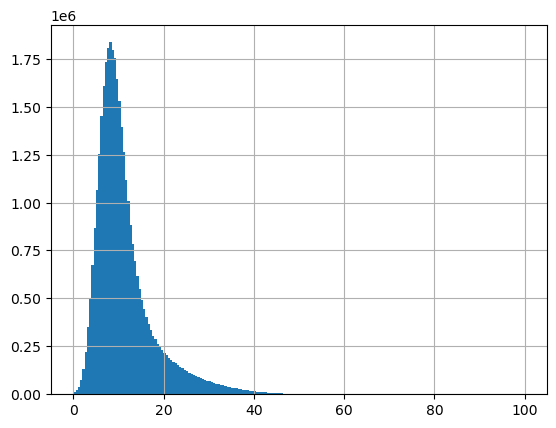

In [20]:
df['avg_mph'].hist(bins=200)
plt.show()

$$ $$

From this, I'm going to filter anything below $1$ mph or above $50$ mph

In [21]:
num_over_60 = (df['avg_mph'] > 50).sum()
num_under_1 = (df['avg_mph'] < 1).sum()

print(f"{num_over_60} trips are over average mph of 50")
print(f"{num_under_1} trips are under average mph of 1")

12854 trips are over average mph of 50
34723 trips are under average mph of 1


In [22]:
df = df[df['avg_mph'] <= 50]
df = df[df['avg_mph'] >=  1]
speed_filtered_rows = df.shape[0]

print(f"{ordered_time_filtered_rows - speed_filtered_rows} rows lost in speed filtering")

93632 rows lost in speed filtering


$$ $$

### Do extra checks

In [23]:
# Check no voided trip payment types
num_voided_trips = len(df[df['payment_type'] == 6])
print(f"{num_voided_trips} voided trip payments")


0 voided trip payments


$$ $$

$$ $$

## Save filtered data as a parquet

Only keep specific columns first

In [24]:
sim_columns = ["tpep_pickup_datetime", "tpep_dropoff_datetime",
               "trip_distance",
               "RatecodeID",
               "PULocationID", "DOLocationID",
               "congestion_surcharge", "airport_fee"]

df = df[sim_columns]
df.to_parquet("2023 yellow taxi/filtered trip parquets/yellow_tripdata_2023.parquet", index=False)

In [25]:
print(f"Final row count: {df.shape[0]:,}")

Final row count: 35,530,878


$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# 2013 taxi cab dataset

concatenate all months into one csv file

In [18]:
import pandas as pd

all_dfs = []

for month in range(1, 13):
    csv_path = f"FOIL data/decompressed/FOIL2013/trip_data_{month}.csv"
    
    print(f"trip_data_{month}.csv")
    df = pd.read_csv(csv_path)
    all_dfs.append(df)


# concatenate
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"Full concatenated shape: {full_df.shape}")

# Save as parquet
full_df.to_parquet("FOIL data/all_trips_data.parquet", index=False)


trip_data_1.csv
trip_data_2.csv
trip_data_3.csv
trip_data_4.csv
trip_data_5.csv
trip_data_6.csv
trip_data_7.csv
trip_data_8.csv
trip_data_9.csv
trip_data_10.csv
trip_data_11.csv
trip_data_12.csv
Full concatenated shape: (173179759, 14)


$$ $$

## Clean the data:

For the simulation, I will only be keeping the following columns:

- tpep_pickup_datetime
- tpep_dropoff_datetime
- trip_distance
- RatecodeID
- PULocationID
- DOLocationID
- congestion_surcharge
- airport_fee

$$ $$

I need to filter and removes with the following column values:

- tpep_pickup_datetime
  - invalid
 
**Note:** There were no NAs within store_and_fwd_flag and vendor_id, so I removed them since I don't care about them

In [1]:
import pandas as pd
import gc

In [2]:
df = pd.read_parquet("FOIL data/all_trips_data.parquet")

print("loaded dataframe")

# replace columns with proper names
column_mapping = {
    'medallion':           'medallion',
    ' hack_license':       'hack_license', 
    ' vendor_id':          'vendor_id',
    ' rate_code':          'rate_code',
    ' store_and_fwd_flag': 'store_and_fwd_flag',
    ' pickup_datetime':    'pickup_datetime',
    ' dropoff_datetime':   'dropoff_datetime',
    ' passenger_count':    'passenger_count', 
    ' trip_time_in_secs':  'trip_time_in_secs', 
    ' trip_distance':      'trip_distance',
    ' pickup_longitude':   'pickup_longitude', 
    ' pickup_latitude':    'pickup_latitude', 
    ' dropoff_longitude':  'dropoff_longitude',
    ' dropoff_latitude':   'dropoff_latitude'
}

print("remapping columns...")
df = df.rename(columns=column_mapping)


print("converting datetimes...")
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce', cache=True).astype("datetime64[us]")
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce', cache=True).astype("datetime64[us]")


print("dropping store_and_fwd_flag and vendor_id")
df.drop(columns=['store_and_fwd_flag', 'vendor_id'], inplace=True)


print("done")


loaded dataframe
remapping columns...
converting datetimes...
dropping store_and_fwd_flag and vendor_id
done


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173179759 entries, 0 to 173179758
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   medallion          int64         
 1   hack_license       int64         
 2   rate_code          int64         
 3   pickup_datetime    datetime64[us]
 4   dropoff_datetime   datetime64[us]
 5   passenger_count    int64         
 6   trip_time_in_secs  int64         
 7   trip_distance      float64       
 8   pickup_longitude   float64       
 9   pickup_latitude    float64       
 10  dropoff_longitude  float64       
 11  dropoff_latitude   float64       
dtypes: datetime64[us](2), float64(5), int64(5)
memory usage: 15.5 GB


In [4]:
#df.to_parquet("after_first_cell.parquet", index=False)

$$ $$

$$ $$

$$ $$

### Filter out invalid distance measurements

keep trips where 0 < d <= 100

In [6]:
num_zero = (df['trip_distance'] <= 0).sum()
num_over_100 = (df['trip_distance'] > 100).sum()

print(f"There are {num_zero} zero distance rows and {num_over_100} >100 distance rows.") 

There are 1129639 zero distance rows and 776 >100 distance rows.


In [7]:
original_rows = df.shape[0]
df = df[ (df['trip_distance'] > 0) & (df['trip_distance'] <= 100) ]
dist_filtered_rows = df.shape[0]

print(f"{original_rows - dist_filtered_rows} rows lost in distance filtering")

1130415 rows lost in distance filtering


$$ $$

### Filter out pickup and dropoff times outside of 2013

In [8]:
start = pd.Timestamp("2013-01-01")
end   = pd.Timestamp("2014-01-01")

df = df[(df['pickup_datetime'] >= start) & (df['dropoff_datetime'] < end)]
date_filtered_rows = df.shape[0]

print(f"{dist_filtered_rows - date_filtered_rows} rows lost in time filtering")

1976 rows lost in time filtering


$$ $$

### Filter out rows with dropoff before or at pickup

In [9]:
dropoff_before_pickup = (df["dropoff_datetime"] <= df["pickup_datetime"]).sum()
print(f"{dropoff_before_pickup} rows with dropoff before or at pickup")

187427 rows with dropoff before or at pickup


In [10]:
df = df[df["dropoff_datetime"] > df["pickup_datetime"]]
ordered_time_filtered_rows = df.shape[0]

print(f"{date_filtered_rows - ordered_time_filtered_rows} rows lost in pickup/dropoff order filtering")

187427 rows lost in pickup/dropoff order filtering


$$ $$

$$ $$

### Filter rows with invalid coordinates

The code below should tell the boundaries of the 2023 dataset. When run, it outputs:

<br>

Longitude range: -74.25559136315209 to -73.7000090639354 <br>
Latitude range: 40.496115395170555 to 40.915532777002774

In [8]:
# NOTE: Have to run with CS5805 kernel
import geopandas as gpd

zones = gpd.read_file("2023 yellow taxi/taxi_zones/taxi_zones.shp")

# need to convert back to latitude longitude coordinates
zones_wgs = zones.to_crs(epsg=4326)
minx, miny, maxx, maxy = zones_wgs.total_bounds

print("Longitude range:", minx, "to", maxx)
print("Latitude range:", miny, "to", maxy)

ModuleNotFoundError: No module named 'geopandas'

In [11]:
# filter the dataframe according to the coordinate bounds
min_long, max_long = -74.25559136315209, -73.7000090639354
min_lat,  max_lat  = 40.496115395170555, 40.915532777002774

df = df[df["pickup_longitude"].between(min_long, max_long) & df["dropoff_longitude"].between(min_long, max_long) &
        df["pickup_latitude"].between(min_lat, max_lat)    & df["dropoff_latitude"].between(min_lat, max_lat)]
coordinates_filtered_rows = df.shape[0]

print(f"{ordered_time_filtered_rows - coordinates_filtered_rows} rows lost in coordinate boundary filtering")

3195854 rows lost in coordinate boundary filtering


$$ $$

$$ $$

### Print out NA value counts for each column

In [12]:
print(df.isna().sum())

medallion            0
hack_license         0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64


$$ $$

### Check passenger counts

I don't actually care about passenger counts, but this could indicate bad data.

So, I'm going to go ahead and filter them out anyways

In [13]:
num_NA_counts = (df['passenger_count'].isna()).sum()
num_zero_counts = (df['passenger_count'] == 0).sum()

print(f"There are {num_NA_counts} NA passenger counts and {num_zero_counts} passenger counts of 0")

There are 0 NA passenger counts and 580 passenger counts of 0


In [14]:
df = df[df['passenger_count'] != 0]
zero_passenger_filtered_rows = df.shape[0]

print(f"{coordinates_filtered_rows - zero_passenger_filtered_rows} rows lost in 0 passenger count filtering")

580 rows lost in 0 passenger count filtering


$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

### Create an average speed column and filter unrealistic speeds

In [15]:
# create duration and speed columns
df['duration_hours'] = ((df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 3600)
df["avg_mph"] = df["trip_distance"] / df["duration_hours"]

# remove anything over 100mph to start
df = df[df['avg_mph'] < 100]

# remove anything over 3 hours to start
df = df[df['duration_hours'] < 3]

In [16]:
import matplotlib.pyplot as plt

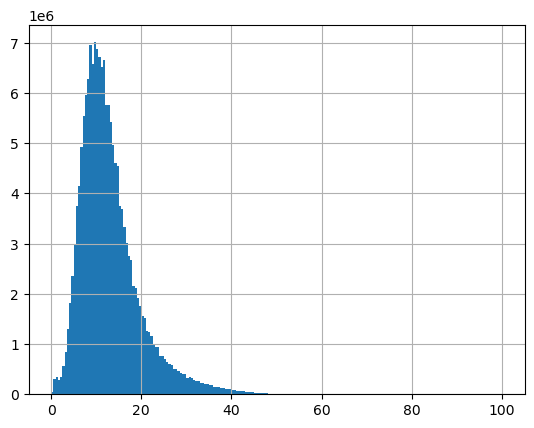

In [17]:
df['avg_mph'].hist(bins=200)
plt.show()

$$ $$

From this, I'm going to filter anything below $1$ mph or above $50$ mph

In [18]:
num_over_60 = (df['avg_mph'] > 50).sum()
num_under_1 = (df['avg_mph'] < 1).sum()

print(f"{num_over_60} trips are over average mph of 50")
print(f"{num_under_1} trips are under average mph of 1")

151515 trips are over average mph of 50
333310 trips are under average mph of 1


In [19]:
df = df[df['avg_mph'] <= 50]
df = df[df['avg_mph'] >=  1]
speed_filtered_rows = df.shape[0]

print(f"{zero_passenger_filtered_rows - speed_filtered_rows} rows lost in speed filtering")

599243 rows lost in speed filtering


$$ $$

### Filter out invalid rate codes

Only keep codes between 1 and 6

In [20]:
num_invalid_rates = ((df['rate_code'] < 1) | (df['rate_code'] > 6)).sum()
print(f"{num_invalid_rates} rows have invalid rate codes")

df = df[(df['rate_code'] >= 1) & (df['rate_code'] <= 6)]
rate_filtered_rows = df.shape[0]

print(f"{speed_filtered_rows - rate_filtered_rows} rows lost in rate code filtering")

25435 rows have invalid rate codes
25435 rows lost in rate code filtering


$$ $$

$$ $$

## Save filtered data as a parquet

Only keep specific columns first

In [12]:
sim_columns = ["medallion", "hack_license", "rate_code",
               "pickup_datetime", "dropoff_datetime",
               "trip_distance",
               "pickup_longitude", "pickup_latitude",
               "dropoff_longitude", "dropoff_latitude"]

#df = df[sim_columns]
#df.to_parquet("FOIL data/filtered/FOIL_filtered_all.parquet", index=False)

In [22]:
print(f"Final row count: {df.shape[0]:,}")

Final row count: 168,038,829


$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Combine 2013 and 2023 datasets

## Separate 2013 day by day of the week

In [1]:
import pandas as pd
import os

In [ ]:
# import large dataset
full_df = pd.read_parquet("FOIL data/filtered/FOIL_filtered_all.parquet")

In [5]:
# add an id column
full_df['id'] = full_df.index

In [9]:
# separate and save into days of the week
full_df['day_of_week'] = full_df['pickup_datetime'].dt.dayofweek #Monday = 0

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(7):

    sub_df = full_df[full_df['day_of_week'] == i]

    os.mkdir(f"FOIL data/filtered/{days[i]}")
    sub_df.to_parquet(f"FOIL data/filtered/{days[i]}/filtered.parquet", index=False)
    

$$ $$

## Go through day of the week saves and add location IDs

In [1]:
# NOTE: have to run with CS5805 kernel
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


In [2]:
def add_location_ids(day):
    print(f"Starting {day}:")
    df2013 = pd.read_parquet(f"FOIL data/filtered/{day}/filtered.parquet")  # or CSV if needed
    #df2013.info()

    # Create geometry columns
    df2013["pickup_geometry"] = gpd.points_from_xy(df2013.pickup_longitude, df2013.pickup_latitude)
    df2013["dropoff_geometry"] = gpd.points_from_xy(df2013.dropoff_longitude, df2013.dropoff_latitude)

    # Load taxi zones shapefile
    zones = gpd.read_file("2023 yellow taxi/taxi_zones/taxi_zones.shp").to_crs("EPSG:4326")

    # Do pickup geometry
    gdf2013 = gpd.GeoDataFrame(df2013, geometry="pickup_geometry", crs="EPSG:4326")
    gdf2013.set_crs("EPSG:4326", inplace=True)
    
    # Assign pickup zone
    gdf2013 = gpd.sjoin(gdf2013.set_geometry("pickup_geometry"), zones, how="left", predicate="within")
    gdf2013 = gdf2013.rename(columns={"LocationID": "PULocationID_2013"})

    # Do dropoff geometry

    # Drop the index_right column from the first join
    if 'index_right' in gdf2013.columns:
        gdf2013 = gdf2013.drop(columns=['index_right'])
    
    # --- Second: dropoff join ---
    # Switch the active geometry to dropoff points
    gdf2013 = gpd.GeoDataFrame(
        gdf2013,
        geometry='dropoff_geometry',
        crs='EPSG:4326'
    )
    
    gdf2013 = gpd.sjoin(
        gdf2013,
        zones[['LocationID', 'geometry']],
        how="left",
        predicate="within"
    )
    
    gdf2013 = gdf2013.rename(columns={"LocationID": "DOLocationID_2013"})
    
    # Clean up again if you like
    if 'index_right' in gdf2013.columns:
        gdf2013 = gdf2013.drop(columns=['index_right'])



    num_unique_pickup_zones = len(gdf2013['PULocationID_2013'].unique())
    print(f"{num_unique_pickup_zones} unique pickup zone values")

    num_unique_dropoff_zones = len(gdf2013['DOLocationID_2013'].unique())
    print(f"{num_unique_dropoff_zones} unique dropoff zone values")
    print("\n")


    keep_cols = ['medallion', 'hack_license', 'rate_code', 'pickup_datetime', 'dropoff_datetime', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'id', 'day_of_week', 'PULocationID_2013', 'DOLocationID_2013']

    export = gdf2013[keep_cols].copy()

    
    print(export.isna().sum())
    #export = export.dropna()
    # keep NAs for continuity and then filter when making distribution

    print("\n\n\n")
    
    export.to_parquet(f"FOIL data/filtered/{day}/location_IDs.parquet", index=False)

    

In [3]:
days_to_do = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days_to_do:
    add_location_ids(day)

Starting Monday:
258 unique pickup zone values
261 unique dropoff zone values


medallion                0
hack_license             0
rate_code                0
pickup_datetime          0
dropoff_datetime         0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
id                       0
day_of_week              0
PULocationID_2013    20842
DOLocationID_2013    43701
dtype: int64




Starting Tuesday:
260 unique pickup zone values
261 unique dropoff zone values


medallion                0
hack_license             0
rate_code                0
pickup_datetime          0
dropoff_datetime         0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
id                       0
day_of_week              0
PULocationID_2013    23412
DOLocationID_2013    50695
dtype: int64




Starting Wednesday:
260 unique pickup zone values

$$ $$

# Sort and split datasets by 30 day intervals 

In [26]:
import pandas as pd

In [46]:
# Sunday to start on
start_2023 =  pd.Timestamp('2023-01-08') # Jan 8th 2023
start_2013 =  pd.Timestamp('2013-01-06') # Jan 6th 2013

# Friday to end on (include Christmas)
end_2023 = start_2023 + pd.Timedelta(days=355)
end_2013 = start_2013 + pd.Timedelta(days=355)

In [50]:
# load in 2023 data and create new date column and save
df_2023 = pd.read_parquet("2023 yellow taxi/filtered trip parquets/yellow_tripdata_2023.parquet")

# create day column (days since start based on pickup)
df_2023['days'] = (df_2023['tpep_pickup_datetime'] - start_2023).dt.days


In [55]:
# create 2023 id column
df_2023['2023_id'] = df_2023.index


In [65]:
# only use important columns for kNN matching
df_2023_export = df_2023[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'DOLocationID', 'days', '2023_id']].copy()


# 30 day interval chunk flag
df_2023_export['chunk_30d'] = (df_2023_export['days'] // 30).astype(int)

# go through and save each chunk separately
for i, chunk in df_2023_export.groupby('chunk_30d'):
    if i >= 0:
        chunk.to_parquet(f"distilled taxi data/batched/2023/chunk{i}.parquet", index=False)



$$ $$

### Build back, select, and chunk 2013 data

In [1]:
import pandas as pd

In [4]:
all_dfs = []

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    file_path = f"FOIL data/filtered/{day}/location_IDs.parquet"
    
    df = pd.read_parquet(file_path)

    df = df[['medallion', 'pickup_datetime', 'dropoff_datetime', 'trip_distance', 'PULocationID_2013', 'DOLocationID_2013', 'id']]
    
    all_dfs.append(df)


# concatenate
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"Full concatenated shape: {full_df.shape}")

Full concatenated shape: (168038833, 7)


In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168038833 entries, 0 to 168038832
Data columns (total 7 columns):
 #   Column             Dtype         
---  ------             -----         
 0   medallion          int64         
 1   pickup_datetime    datetime64[us]
 2   dropoff_datetime   datetime64[us]
 3   trip_distance      float64       
 4   PULocationID_2013  float64       
 5   DOLocationID_2013  float64       
 6   id                 int64         
dtypes: datetime64[us](2), float64(3), int64(2)
memory usage: 8.8 GB


In [68]:
df = pd.read_parquet("FOIL data/filtered/Monday/location_IDs.parquet")

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21774350 entries, 0 to 21774349
Data columns (total 14 columns):
 #   Column             Dtype         
---  ------             -----         
 0   medallion          int64         
 1   hack_license       int64         
 2   rate_code          int64         
 3   pickup_datetime    datetime64[us]
 4   dropoff_datetime   datetime64[us]
 5   trip_distance      float64       
 6   pickup_longitude   float64       
 7   pickup_latitude    float64       
 8   dropoff_longitude  float64       
 9   dropoff_latitude   float64       
 10  id                 int64         
 11  day_of_week        int32         
 12  PULocationID_2013  float64       
 13  DOLocationID_2013  float64       
dtypes: datetime64[us](2), float64(7), int32(1), int64(4)
memory usage: 2.2 GB


$$ $$

$$ $$

# Create distribution samples for total number of taxis

Separate distributions by day of the week and hour

Data is taken from filtered 2013 trips and is based on pickup time

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

$$ $$
## Investigate distribution behaivor for Monday

In [35]:
# load Monday data
df = pd.read_parquet("FOIL data/filtered/Monday/filtered.parquet")
df = df[['hack_license', 'pickup_datetime']]

# Create pickup hour
df['hour'] = df['pickup_datetime'].dt.floor('h')

# create dataframe of driver counts over hour datetimes
hourly_active_drivers = (
    df.groupby('hour')['hack_license']
      .nunique()
      .sort_index()
)

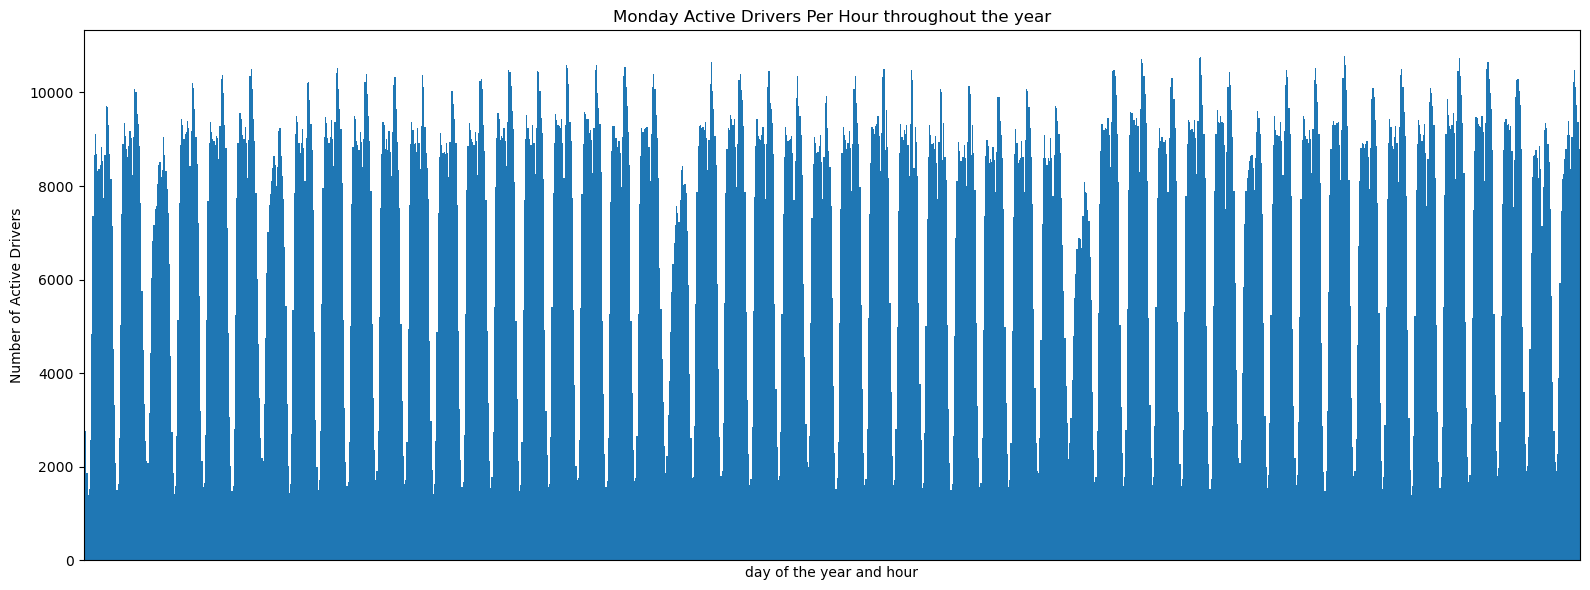

In [36]:

plt.figure(figsize=(16, 6))
hourly_active_drivers.plot(kind='bar', width=1)

plt.title("Monday Active Drivers Per Hour throughout the year")
plt.xlabel("day of the year and hour")
plt.xticks([])
plt.ylabel("Number of Active Drivers")
plt.tight_layout()
plt.show()

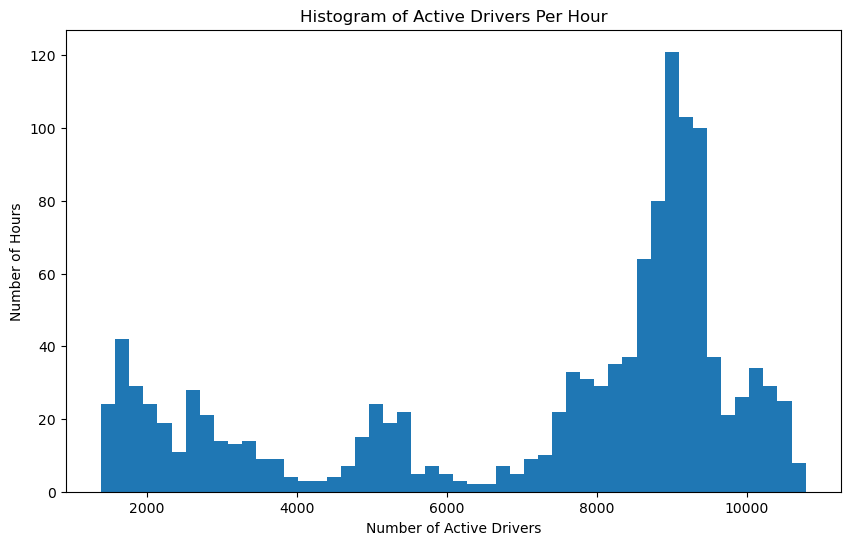

In [37]:
plt.figure(figsize=(10,6))

plt.hist(hourly_active_drivers.values, bins=50)

plt.title("Histogram of Active Drivers Per Hour")
plt.xlabel("Number of Active Drivers")
plt.ylabel("Number of Hours")
plt.show()

<Axes: title={'center': 'Avg Active Drivers per Hour of Day'}, xlabel='hour_of_day'>

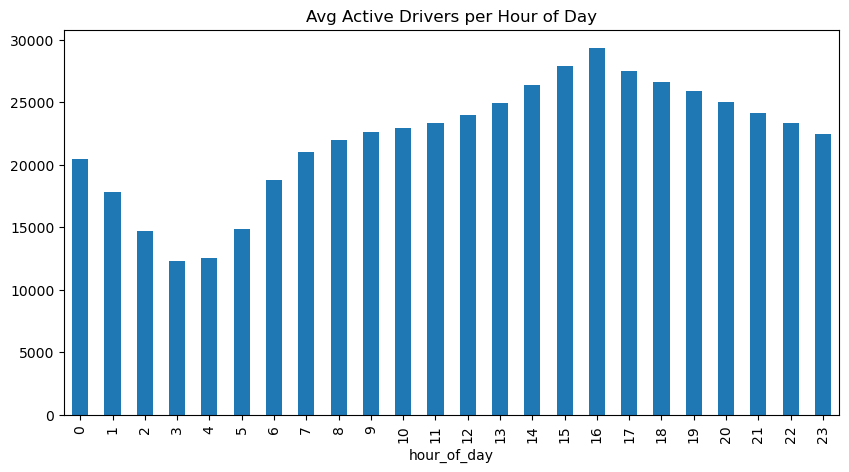

In [38]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour

drivers_by_hour = (
    df.groupby('hour_of_day')['hack_license']
      .nunique()
)

drivers_by_hour.plot(kind='bar', figsize=(10,5), title="Avg Active Drivers per Hour of Day")


$$ $$

## Get distribution information for number of drivers for a weekday's hours

I'm going to create a dataframe of hours vs days of the week with numpy arrays as the entries

In [55]:
full_df = pd.read_parquet("FOIL data/filtered/FOIL_filtered_all.parquet")

full_df = full_df[['hack_license', 'pickup_datetime']].copy()

In [56]:
# create pickup hour again
full_df['pickup_hour'] = full_df['pickup_datetime'].dt.floor('h')

# Count unique drivers per hour
hourly = (
    full_df.groupby('pickup_hour')['hack_license']
      .nunique()
      .rename('active_drivers')
      .reset_index()
)

In [57]:
hourly.head()

,pickup_hour,active_drivers
0,2013-01-01 00:00:00,9646
1,2013-01-01 01:00:00,9847
2,2013-01-01 02:00:00,9502
3,2013-01-01 03:00:00,8808
4,2013-01-01 04:00:00,7306


In [58]:
# create flags for day of the week and hour
hourly['day'] = hourly['pickup_hour'].dt.dayofweek # Monday = 0
hourly['hour'] = hourly['pickup_hour'].dt.hour

In [59]:
# group into a dataframe of numpy arrays
distribution_df = (
    hourly
    .groupby(['hour', 'day'])['active_drivers']
    .apply(np.array)            # collect into numpy arrays
    .unstack()                   # columns become days of week
    .sort_index()
)

In [62]:
distribution_df.head()

day,0,1,2,3,4,5,6
hour,,,,,,,
0,"[4082, 4509, 5747, 4362, 5652, 4860, 6019, 543...","[9646, 5135, 5452, 4476, 4954, 5047, 5953, 497...","[3837, 5709, 6744, 6340, 6390, 6384, 7475, 616...","[5329, 6512, 7154, 6610, 7423, 7622, 7971, 731...","[6706, 8252, 8549, 8550, 9281, 9335, 9413, 901...","[9680, 9941, 10409, 9853, 10590, 3031, 10429, ...","[9749, 10295, 10241, 10449, 10270, 9580, 10254..."
1,"[2769, 3327, 4502, 2750, 3198, 3071, 4632, 334...","[9847, 3381, 3389, 2790, 3172, 3040, 3900, 299...","[2467, 3754, 4268, 3741, 3995, 3853, 4811, 374...","[3510, 4327, 4618, 4133, 4857, 4832, 5272, 463...","[4537, 5902, 6142, 5919, 6634, 6969, 7205, 648...","[8772, 9086, 9620, 8993, 9891, 2510, 9680, 993...","[9146, 9770, 9664, 9968, 9747, 9114, 9837, 982..."
2,"[1858, 2073, 3339, 1877, 2131, 2023, 3467, 202...","[9502, 2237, 2237, 1759, 2041, 1966, 2325, 183...","[1625, 2392, 2691, 2294, 2579, 2383, 3097, 241...","[2295, 2844, 3050, 2624, 3087, 3103, 3346, 293...","[3078, 4043, 4244, 3960, 4478, 4851, 5055, 436...","[7378, 8019, 8428, 7867, 8768, 2090, 8580, 876...","[8227, 8968, 8855, 9191, 8927, 8324, 9017, 899..."
3,"[1391, 1496, 2562, 1410, 1568, 1491, 2614, 144...","[8808, 1605, 1574, 1290, 1404, 1372, 1696, 135...","[1194, 1829, 1967, 1625, 1786, 1749, 2141, 170...","[1635, 1979, 2096, 1738, 2090, 2106, 2259, 198...","[2213, 2795, 2978, 2746, 3070, 3452, 3498, 306...","[5850, 6403, 6899, 6297, 7219, 1689, 7056, 721...","[6906, 7765, 7592, 7856, 7580, 7165, 7735, 779..."
4,"[1523, 1641, 2130, 1599, 1665, 1586, 2195, 162...","[7306, 1477, 1496, 1388, 1408, 1433, 1603, 145...","[1450, 1685, 1837, 1634, 1693, 1597, 1965, 163...","[1652, 1825, 1952, 1669, 1844, 1940, 2112, 191...","[1931, 2363, 2518, 2352, 2476, 2955, 2772, 251...","[4187, 4451, 5023, 4388, 5111, 1261, 5055, 515...","[4889, 5726, 5661, 5713, 5340, 5238, 5737, 567..."


In [64]:
# save the distribution array dataframe as a pickle object
distribution_df.to_pickle("sim_info/driver_count_arrays.pkl")

$$ $$

## Do the same thing for changes in driver count between hours

This is to avoid having unrealistic changes in driver count for the simulation

In [67]:
hourly

,pickup_hour,active_drivers,day,hour
0,2013-01-01 00:00:00,9646,1,0
1,2013-01-01 01:00:00,9847,1,1
2,2013-01-01 02:00:00,9502,1,2
3,2013-01-01 03:00:00,8808,1,3
4,2013-01-01 04:00:00,7306,1,4
...,...,...,...,...
8754,2013-12-31 19:00:00,10212,1,19
8755,2013-12-31 20:00:00,10477,1,20
8756,2013-12-31 21:00:00,10689,1,21
8757,2013-12-31 22:00:00,10598,1,22


In [71]:
# add a change in hour column
# this is shifted back 1 so that [hour 0] means change between hour 0 and hour 1

hourly['delta_drivers'] = hourly['active_drivers'].shift(-1) - hourly['active_drivers']

hourly = hourly.dropna()
hourly

,pickup_hour,active_drivers,day,hour,delta_drivers
0,2013-01-01 00:00:00,9646,1,0,201.0
1,2013-01-01 01:00:00,9847,1,1,-345.0
2,2013-01-01 02:00:00,9502,1,2,-694.0
3,2013-01-01 03:00:00,8808,1,3,-1502.0
4,2013-01-01 04:00:00,7306,1,4,-2395.0
...,...,...,...,...,...
8751,2013-12-31 16:00:00,8263,1,16,647.0
8752,2013-12-31 17:00:00,8910,1,17,889.0
8753,2013-12-31 18:00:00,9799,1,18,413.0
8754,2013-12-31 19:00:00,10212,1,19,265.0


In [72]:
# create distribution dataframe again
distribution_df = (
    hourly
    .groupby(['hour', 'day'])['delta_drivers']
    .apply(np.array)            # collect into numpy arrays
    .unstack()                   # columns become days of week
    .sort_index()
)

In [74]:
# save the distribution array dataframe as a pickle object
distribution_df.to_pickle("sim_info/driver_delta_arrays.pkl")

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Create distribution of distance/time between trips

I want to create a sample distribution of distance between dropoffs and pickups between two different sectors

I will use the duration and mph to determine whether a in between is a break or a drive between rides.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

### Load in all 2013 data and select important columns

In [3]:
all_dfs = []

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    print(f"Loading: {day}")
    
    file_path = f"FOIL data/filtered/{day}/location_IDs.parquet"
    
    df = pd.read_parquet(file_path)

    df = df[['hack_license', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude', 'PULocationID_2013', 'DOLocationID_2013']].copy()
    
    all_dfs.append(df)

del df

# concatenate
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"Full concatenated shape: {full_df.shape}")

Loading: Monday
Loading: Tuesday
Loading: Wednesday
Loading: Thursday
Loading: Friday
Loading: Saturday
Loading: Sunday
Full concatenated shape: (168038833, 9)


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168038833 entries, 0 to 168038832
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   hack_license       int64         
 1   pickup_datetime    datetime64[us]
 2   dropoff_datetime   datetime64[us]
 3   pickup_longitude   float64       
 4   pickup_latitude    float64       
 5   dropoff_longitude  float64       
 6   dropoff_latitude   float64       
 7   PULocationID_2013  float64       
 8   DOLocationID_2013  float64       
dtypes: datetime64[us](2), float64(6), int64(1)
memory usage: 11.3 GB


$$ $$

### Create batch partitions and write the filtered dataframes to their folder

In [5]:
batch_size = 1500

In [6]:
licenses = full_df["hack_license"].unique()

batches = [
    (i, licenses[i*batch_size:(i+1)*batch_size])
    for i in range(int(np.ceil(len(licenses) / batch_size)))
]

In [7]:
total_rows_written = 0

out_folder = "distilled taxi data/between trip batches"

# empty the out folder
import shutil
import os

if os.path.isdir(out_folder):
    shutil.rmtree(out_folder)

os.mkdir(out_folder)

for batch in tqdm(batches):
    
    idx, licenses = batch

    # filter out batch df from full df
    batch_df = full_df[full_df["hack_license"].isin(licenses)].copy()

    # create and batch save folder
    os.mkdir(out_folder + f"/batch_{idx}")

    # write parquet file for batch
    out_path = out_folder + f"/batch_{idx}/batch_df.parquet"
    batch_df.to_parquet(out_path, index=False)

    total_rows_written += len(batch_df)

print("total_rows_written:", total_rows_written)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [02:02<00:00,  4.22s/it]

total_rows_written: 168038833


In [ ]:
import gc

del full_df
del batch_df
del all_dfs

gc.collect()


In [10]:
import multiprocessing
from multiprocessing import Pool
import batch_processing_helper

In [11]:
batch_nums = list(range(len(batches)))
print("Number of batches:", len(batch_nums))

#sys.exit()
if __name__ == '__main__':
    pool = Pool(processes=15)
    batch_results = pool.map(batch_processing_helper.process_saved_batch, batch_nums)



Number of batches: 29


In [12]:
total = 0

for b in batch_results:
    total += b[1]

print(total)

168038833


$$ $$

$$ $$

## Concatenate all batch between trip results to one dataframe

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# get all batch folder names
base_path = Path("distilled taxi data/between trip batches")

batch_folders = [p.name for p in base_path.iterdir() if p.is_dir()]

In [3]:
all_dfs = []

for batch_folder in batch_folders:    
    file_path = f"distilled taxi data/between trip batches/{batch_folder}/batch_result.parquet"
    
    df = pd.read_parquet(file_path)
    
    all_dfs.append(df)

del df

# concatenate
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"Full concatenated shape: {full_df.shape}")

del all_dfs

Full concatenated shape: (168038833, 9)


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168038833 entries, 0 to 168038832
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   hack_license           int64         
 1   dropoff_datetime       datetime64[us]
 2   dropoff_longitude      float64       
 3   dropoff_latitude       float64       
 4   DOLocationID_2013      float64       
 5   next_pickup_time       datetime64[us]
 6   next_pickup_latitude   float64       
 7   next_pickup_longitude  float64       
 8   next_PULocationID      float64       
dtypes: datetime64[us](2), float64(6), int64(1)
memory usage: 11.3 GB


$$ $$

### remove any nas (either last dropoff or invalid location ID)

In [5]:
full_df.isna().sum()

hack_license                  0
dropoff_datetime              0
dropoff_longitude             0
dropoff_latitude              0
DOLocationID_2013        353837
next_pickup_time          42569
next_pickup_latitude      42569
next_pickup_longitude     42569
next_PULocationID        207855
dtype: int64

In [6]:
full_df = full_df.dropna().copy()

In [7]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167559796 entries, 0 to 168038831
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   hack_license           int64         
 1   dropoff_datetime       datetime64[us]
 2   dropoff_longitude      float64       
 3   dropoff_latitude       float64       
 4   DOLocationID_2013      float64       
 5   next_pickup_time       datetime64[us]
 6   next_pickup_latitude   float64       
 7   next_pickup_longitude  float64       
 8   next_PULocationID      float64       
dtypes: datetime64[us](2), float64(6), int64(1)
memory usage: 12.5 GB


### Save overall dataframe

In [8]:
full_df.to_parquet("distilled taxi data/between_trip_overall.parquet")

$$ $$

$$ $$

$$ $$

$$ $$

## Create columns for distance and time


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("distilled taxi data/between_trip_overall.parquet")

df['DOLocationID_2013'] = df['DOLocationID_2013'].astype('category')
df['next_PULocationID'] = df['next_PULocationID'].astype('category')

df.head()

,hack_license,dropoff_datetime,dropoff_longitude,dropoff_latitude,DOLocationID_2013,next_pickup_time,next_pickup_latitude,next_pickup_longitude,next_PULocationID
0,2013000018,2013-01-01 00:07:00,-74.004288,40.750999,246.0,2013-01-01 00:12:00,40.751789,-74.004265,246.0
1,2013000018,2013-01-01 00:26:00,-73.988892,40.726990,79.0,2013-01-01 00:27:00,40.727558,-73.990906,79.0
2,2013000018,2013-01-01 00:46:00,-73.980667,40.660091,257.0,2013-01-01 00:48:00,40.659977,-73.980751,257.0
3,2013000018,2013-01-01 00:51:00,-73.977142,40.645367,133.0,2013-01-01 01:00:00,40.660595,-73.962837,190.0
4,2013000018,2013-01-01 01:08:00,-73.949722,40.668915,62.0,2013-01-01 01:14:00,40.674068,-73.953850,61.0


$$ $$

### Distance column

Doing first because of memory issues (can get ride of long, lat columns)

In [3]:
# Miles per degree for New York City
MILES_PER_LAT = 69.0
MILES_PER_LON = 69.0 * np.cos(np.radians(df['dropoff_latitude']))

df['euclidean_miles'] = np.sqrt(
    ((df['next_pickup_latitude'] - df['dropoff_latitude']) * MILES_PER_LAT) ** 2 +
    ((df['next_pickup_longitude'] - df['dropoff_longitude']) * MILES_PER_LON) ** 2
)

In [4]:
# drop lat and long columns
df.drop(columns=['dropoff_longitude', 'dropoff_latitude', 'next_pickup_latitude', 'next_pickup_longitude'], inplace=True)

import gc
gc.collect()


52

### Time Column

In [5]:
df['minutes_between'] = (df['next_pickup_time'] - df['dropoff_datetime']).dt.total_seconds() / 60


In [6]:
# remove any negative times
num_negative = (df['minutes_between'] < 0).sum()
print(f"There are {num_negative} negative durations")

df = df[df['minutes_between'] > 0]


There are 68034 negative durations


$$ $$

## Saved with basic filtering

In [8]:
df.to_parquet("distilled taxi data/between_trip_dist_dur.parquet", index=False)

$$ $$

$$ $$

$$ $$

# Investigate in between distributions

Try to split between next pickup, breaks, and shifts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("distilled taxi data/between_trip_dist_dur.parquet")

$$ $$

## Look at duration distribution

In [11]:
durations = df['minutes_between'].to_numpy()

# only keep durations under 1 day
durations = durations[durations < (60*24)]

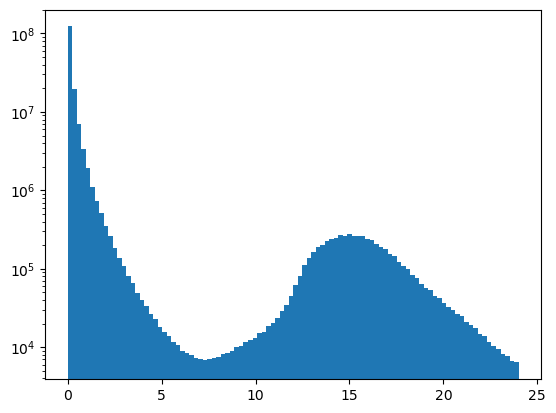

In [18]:

plt.hist(durations / 60, bins=100)
plt.yscale('log')
plt.show()

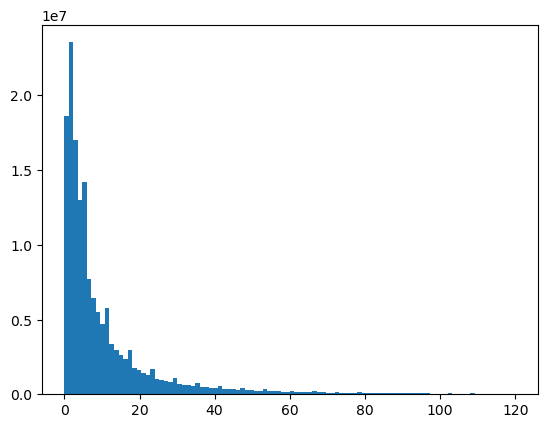

In [21]:
plt.hist(durations[durations < (60*2)], bins=100)
plt.show()

$$ $$

## Look at speed distribution

In [33]:
df['mph'] = df['euclidean_miles'] / (df['minutes_between'] / 60)

<Axes: >

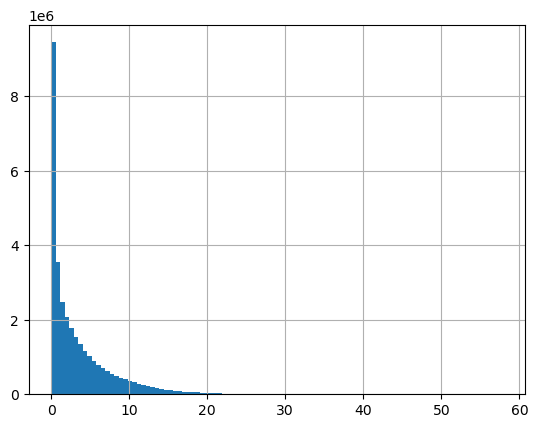

In [34]:
# look at durations over 20 minutes
over_20 = df[df['minutes_between'] > 20]

over_20['mph'].hist(bins = 100)

$$ $$

## Classify in-between trips and shift changes

From this, I will define:
- in-between trip:
  - (duration < 20 minutes) or (duration > 20 minutes and mph > 5)
- shift change
  - 7 hours < duration < 20 hours

In [38]:
in_betweens = df[ ((df['minutes_between'] < 20) | ((df['minutes_between'] > 20) & (df['mph'] > 5))) ]

In [40]:
in_betweens.to_parquet("distilled taxi data/in_betweens.parquet", index=False)

$$ $$

In [41]:
shift_changes = df[ (df['minutes_between'] > 7*60) & (df['minutes_between'] <  20*60) ]

In [43]:
shift_changes.to_parquet("distilled taxi data/shift_changes.parquet", index=False)

$$ $$

$$ $$

# Create distribution matrix for minutes between


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
in_betweens = pd.read_parquet("distilled taxi data/in_betweens.parquet")

In [3]:

# drop all columns other than: distance, minutes, and location IDs
in_betweens.drop(columns=['hack_license', 'dropoff_datetime', 'next_pickup_time', 'mph'], inplace=True)

In [5]:
in_betweens = in_betweens.rename(columns={
    'DOLocationID_2013' : 'DOLocationID',
    'next_PULocationID' : 'PULocationID',
    'euclidean_miles'   : 'miles',
    'minutes_between'   : 'minutes',    
})

In [6]:
in_betweens.head()

,DOLocationID,PULocationID,miles,minutes
0,246.0,246.0,0.054523,5.0
1,79.0,79.0,0.112368,1.0
2,257.0,257.0,0.009011,2.0
3,133.0,190.0,1.290321,9.0
4,62.0,61.0,0.416047,6.0


In [8]:
# 1) Clean IDs (important since yours are floats like 246.0)
d = in_betweens.dropna(subset=["PULocationID", "DOLocationID", "miles", "minutes"]).copy()
d["PULocationID"] = d["PULocationID"].astype("int32")
d["DOLocationID"] = d["DOLocationID"].astype("int32")

# 2) Collect all occurrences per (PU, DO) into lists
g = (
    d.groupby(["PULocationID", "DOLocationID"], sort=False)
     .agg(
         miles_list=("miles", list),
         minutes_list=("minutes", list),
     )
     .reset_index()
)

# 3) Pivot to matrices (rows=PU, cols=DO, entries=list)
miles_mat = g.pivot(index="PULocationID", columns="DOLocationID", values="miles_list")
minutes_mat = g.pivot(index="PULocationID", columns="DOLocationID", values="minutes_list")

# 4) Optional: replace NaN (no observations) with empty arrays
miles_mat   = miles_mat.applymap(lambda x: np.array(x) if isinstance(x, list) else np.array([]))
minutes_mat = minutes_mat.applymap(lambda x: np.array(x) if isinstance(x, list) else np.array([]))

C:\Users\brandon\AppData\Local\Temp\ipykernel_18848\1332989819.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  miles_mat   = miles_mat.applymap(lambda x: np.array(x) if isinstance(x, list) else np.array([]))
C:\Users\brandon\AppData\Local\Temp\ipykernel_18848\1332989819.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  minutes_mat = minutes_mat.applymap(lambda x: np.array(x) if isinstance(x, list) else np.array([]))


In [10]:
miles_mat.head()

DOLocationID,1,2,3,4,5,6,7,8,9,10,...,254,255,256,257,258,259,260,261,262,263
PULocationID,,,,,,,,,,,,,,,,,,,,,
1,"[0.43229023108027254, 0.09740231710874132, 0.1...",[],[],[11.04362267057317],[],[],"[14.218638062635824, 14.493489618117064]",[],[],[],...,[],[11.507514800979768],[],[],[],[],"[14.95396961970778, 15.006335281225613, 14.881...","[8.680295372943345, 8.865794132233672, 8.60207...",[13.416570684532694],[13.133733192602747]
2,[],"[0.0284619995324227, 0.052468314139869854, 0.0...",[],[],[],[],[],[],[],[],...,[],[10.400324429007853],[],[],[],[],[],[],[],[]
3,[],[],"[0.02635830974589024, 0.03744755174824822, 0.2...",[],[],[],[],[],[],[],...,"[1.2422739608365503, 1.947823131870812, 0.6449...",[],[],[],[],[],[],[],[],[]
4,"[10.586730204077842, 10.557067784359402, 10.46...",[],"[11.835973489092899, 12.244026125134933, 11.73...","[0.14587521255451055, 0.22579406062758592, 0.2...",[],"[10.28137824101214, 9.987414941707723, 10.0567...","[3.5881922277414557, 4.644481318320717, 3.8687...","[4.771924349403957, 4.417584383518923, 5.26233...","[9.839467977866075, 10.431289897116448, 10.407...","[10.191951416230644, 10.471547534683241, 9.779...",...,"[13.54622086666809, 12.552923227833846, 12.322...","[0.9641445568478271, 1.1364849897936435, 1.272...","[1.1417060162639792, 1.864905364566025, 1.7807...","[5.226292581451341, 4.648469319711202, 5.34114...","[6.743093666336213, 7.041459491896881, 6.72644...","[13.327910354915007, 13.002998965934335, 13.41...","[4.584714364794525, 3.679118542821453, 4.02548...","[1.7879790452079893, 2.2043781190402547, 1.956...","[4.159572200938624, 4.1410488065230355, 4.2661...","[4.25711487146184, 4.629846479985144, 3.638006..."
5,[],[],[],[],"[0.24772911499793154, 0.031752915037545015, 0....",[],[],[],[],[],...,[],[],[],[],[],[],[],[],[19.13077248032786],[]


In [11]:
minutes_mat.head()

DOLocationID,1,2,3,4,5,6,7,8,9,10,...,254,255,256,257,258,259,260,261,262,263
PULocationID,,,,,,,,,,,,,,,,,,,,,
1,"[1.1, 1.9333333333333333, 0.31666666666666665,...",[],[],[54.46666666666667],[],[],"[25.0, 140.58333333333334]",[],[],[],...,[],[118.25],[],[],[],[],"[110.26666666666667, 111.68333333333334, 83.23...","[64.0, 50.78333333333333, 30.633333333333333, ...",[44.0],[50.03333333333333]
2,[],"[2.3333333333333335, 3.4166666666666665, 0.666...",[],[],[],[],[],[],[],[],...,[],[121.0],[],[],[],[],[],[],[],[]
3,[],[],"[1.0, 1.45, 3.0, 1.0, 1.0, 4.083333333333333, ...",[],[],[],[],[],[],[],...,"[4.566666666666666, 12.0, 6.583333333333333, 3...",[],[],[],[],[],[],[],[],[]
4,"[59.0, 120.0, 42.0, 55.0, 49.0, 56.0, 43.68333...",[],"[122.0, 35.0, 36.0, 27.0, 26.0, 30.0, 28.0, 46...","[2.0, 3.0, 2.0, 1.0, 2.0, 2.0, 2.0, 3.0, 14.0,...",[],"[28.0, 37.0, 42.0]","[31.0, 37.583333333333336, 26.75, 18.0, 26.65,...","[29.0, 20.933333333333334, 22.133333333333333,...","[30.0, 24.0, 38.0, 59.0, 26.0, 14.366666666666...","[50.13333333333333, 96.0, 27.783333333333335, ...",...,"[28.0, 29.366666666666667, 27.633333333333333,...","[19.5, 13.966666666666667, 16.866666666666667,...","[14.116666666666667, 14.116666666666667, 18.58...","[42.71666666666667, 33.733333333333334, 30.0, ...","[67.38333333333334, 45.85, 28.616666666666667,...","[35.18333333333333, 33.61666666666667, 23.7833...","[13.0, 13.0, 46.4, 28.383333333333333, 20.95, ...","[11.0, 18.383333333333333, 10.166666666666666,...","[25.0, 10.0, 19.033333333333335, 23.3, 11.0, 1...","[15.1, 16.233333333333334, 20.816666666666666,..."
5,[],[],[],[],"[3.9, 1.0, 1.0, 3.0, 6.883333333333334, 1.3833...",[],[],[],[],[],...,[],[],[],[],[],[],[],[],[108.0],[]


In [12]:
miles_mat.to_pickle("sim_info/in_between_miles_arrays.pkl")

In [13]:
minutes_mat.to_pickle("sim_info/in_between_minutes_arrays.pkl")

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Create distribution of shift durations

Make a sampling distribution based on hour of the day and what day of the week

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet("distilled taxi data/between_trip_dist_dur.parquet")

In [4]:
df.drop(columns=['DOLocationID_2013', 'euclidean_miles'], inplace=True)

In [5]:
test = df[df['hack_license'] == 2013000018]

In [6]:
test.head(n=20)

,hack_license,dropoff_datetime,next_pickup_time,next_PULocationID,minutes_between
0,2013000018,2013-01-01 00:07:00,2013-01-01 00:12:00,246.0,5.0
1,2013000018,2013-01-01 00:26:00,2013-01-01 00:27:00,79.0,1.0
2,2013000018,2013-01-01 00:46:00,2013-01-01 00:48:00,257.0,2.0
3,2013000018,2013-01-01 00:51:00,2013-01-01 01:00:00,190.0,9.0
4,2013000018,2013-01-01 01:08:00,2013-01-01 01:14:00,61.0,6.0
5,2013000018,2013-01-01 01:34:00,2013-01-01 01:37:00,223.0,3.0
6,2013000018,2013-01-01 01:42:00,2013-01-01 01:57:00,163.0,15.0
7,2013000018,2013-01-01 02:20:00,2013-01-01 02:23:00,48.0,3.0
8,2013000018,2013-01-01 02:40:00,2013-01-01 02:41:00,24.0,1.0
9,2013000018,2013-01-01 03:05:00,2013-01-01 03:06:00,79.0,1.0


In [7]:
test[test['minutes_between'] > 60 * 9].head(10)

,hack_license,dropoff_datetime,next_pickup_time,next_PULocationID,minutes_between
12,2013000018,2013-01-01 04:12:00,2013-01-01 17:34:00,141.0,802.0
32,2013000018,2013-01-02 00:32:00,2013-01-02 17:31:00,237.0,1019.0
47,2013000018,2013-01-02 23:23:00,2013-01-03 17:19:00,237.0,1076.0
68,2013000018,2013-01-04 00:31:00,2013-01-04 17:32:00,163.0,1021.0
98,2013000018,2013-01-05 04:14:00,2013-01-05 17:45:00,163.0,811.0
129,2013000018,2013-01-06 04:02:00,2013-01-06 17:18:00,146.0,796.0
148,2013000018,2013-01-07 01:11:00,2013-01-07 17:26:00,237.0,975.0
164,2013000018,2013-01-07 23:40:00,2013-01-08 17:28:00,237.0,1068.0
182,2013000018,2013-01-08 22:43:00,2013-01-12 17:20:00,43.0,5437.0
210,2013000018,2013-01-13 04:39:00,2013-01-13 17:38:00,237.0,779.0


$$ $$

$$ $$

From this, I can define a shift as:

- for in_between row with duration > 9 hours:
  - start = row[next_pickup]
  - end = (row + 1)[dropoff]
  - duration = end - start

**note:** I will filter out unresonable shifts later


In [8]:
shift_changes = df[df['minutes_between'] > 60*9]

In [9]:
shift_changes = shift_changes.rename(columns={
    'dropoff_datetime' : 'shift_end',
    'next_pickup_time' : 'next_shift_start',
    'next_PULocationID': 'next_shift_start_LocationID',
})

In [10]:
shift_changes.head()

,hack_license,shift_end,next_shift_start,next_shift_start_LocationID,minutes_between
12,2013000018,2013-01-01 04:12:00,2013-01-01 17:34:00,141.0,802.0
32,2013000018,2013-01-02 00:32:00,2013-01-02 17:31:00,237.0,1019.0
47,2013000018,2013-01-02 23:23:00,2013-01-03 17:19:00,237.0,1076.0
68,2013000018,2013-01-04 00:31:00,2013-01-04 17:32:00,163.0,1021.0
98,2013000018,2013-01-05 04:14:00,2013-01-05 17:45:00,163.0,811.0


### Create shifts dataframe

In [11]:
# make sure rows are in time order within each driver
df = shift_changes.sort_values(["hack_license", "shift_end"]).copy()

# shift_end from the NEXT row (per driver) = end of the shift that started on THIS row
df["next_shift_end"] = df.groupby("hack_license")["shift_end"].shift(-1)

# build shift dataset
shifts = df.assign(
    shift_start=df["next_shift_start"],
    shift_start_location=df["next_shift_start_LocationID"],
    shift_end=df["next_shift_end"],
    shift_duration_min=(df["next_shift_end"] - df["next_shift_start"]).dt.total_seconds() / 60
)[["hack_license", "shift_start", "shift_end", "shift_duration_min", "shift_start_location"]]

# last row per driver has no "next shift_end" -> drop or keep as NaN
shifts = shifts.dropna(subset=["shift_end"]).reset_index(drop=True)

# (optional) quick sanity filter: keep only positive durations
num_negative_shifts = (shifts['shift_duration_min'] < 0).sum()
print(f"There are {num_negative_shifts} negative shifts")

shifts = shifts[shifts["shift_duration_min"] > 0]

There are 0 negative shifts


In [12]:
shifts[shifts['hack_license'] == 2013000018]

,hack_license,shift_start,shift_end,shift_duration_min,shift_start_location
4090,2013000018,2013-01-01 17:34:00,2013-01-02 00:32:00,418.0,141.0
4091,2013000018,2013-01-02 17:31:00,2013-01-02 23:23:00,352.0,237.0
4092,2013000018,2013-01-03 17:19:00,2013-01-04 00:31:00,432.0,237.0
4093,2013000018,2013-01-04 17:32:00,2013-01-05 04:14:00,642.0,163.0
4094,2013000018,2013-01-05 17:45:00,2013-01-06 04:02:00,617.0,163.0
...,...,...,...,...,...
4287,2013000018,2013-12-26 17:13:00,2013-12-27 02:01:00,528.0,237.0
4288,2013000018,2013-12-27 18:01:00,2013-12-28 03:32:00,571.0,163.0
4289,2013000018,2013-12-28 17:19:00,2013-12-29 03:41:00,622.0,237.0
4290,2013000018,2013-12-29 17:02:00,2013-12-30 01:28:00,506.0,237.0


$$ $$

$$ $$

## Filter out unreasonable daily shifts

In [13]:
shifts['hours'] = shifts['shift_duration_min'] / 60

In [14]:
shift_hours = shifts['hours'].to_numpy()



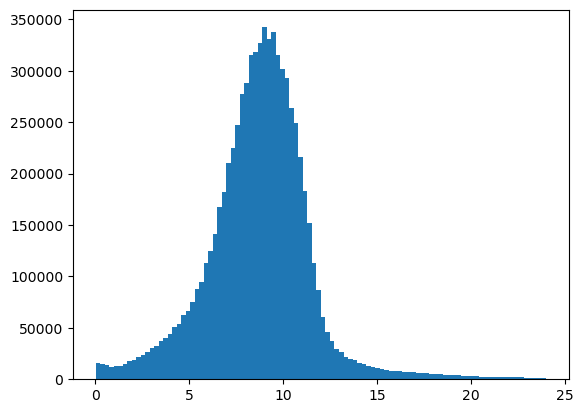

In [15]:
plt.hist(shift_hours[shift_hours < 24], bins=100)
plt.show()

$$ $$

Based on this, I'll define a valid shift as:
- 1 hour < shift < 15 hours

In [16]:
shifts = shifts[ (shifts['hours'] > 1) & (shifts['hours'] < 15) ]

In [18]:
# save shifts dataframe
shifts.to_parquet("distilled taxi data/shift_info_df.parquet")

$$ $$

## Create distribution matrix

In [20]:
# only keep shift start and hours

shift_info = shifts[['shift_start', 'hours', 'shift_start_location']].copy()

In [21]:
shift_info.head()

,shift_start,hours,shift_start_location
0,2013-01-04 16:40:00,11.650000,233.0
1,2013-01-07 11:51:00,12.933333,162.0
2,2013-01-11 17:29:00,11.133333,164.0
3,2013-01-12 18:21:00,10.750000,234.0
4,2013-01-14 13:50:00,10.633333,158.0


In [31]:
# create flags for day of the week and hour
shift_info['day'] = shift_info['shift_start'].dt.dayofweek # Monday = 0
shift_info['hour'] = shift_info['shift_start'].dt.hour

In [32]:
# group into a dataframe of numpy arrays
shift_distribution_df = (
    shift_info
    .groupby(['hour', 'day'])['hours']
    .apply(np.array)            # collect into numpy arrays
    .unstack()                   # columns become days of week
    .sort_index()
)

In [33]:
shift_distribution_df

day,0,1,2,3,4,5,6
hour,,,,,,,
0,"[1.0833333333333333, 1.6666666666666667, 5.116...","[4.2, 12.9, 2.1041666666666665, 1.586944444444...","[4.133333333333334, 4.616666666666666, 2.29916...","[3.3666666666666667, 13.433333333333334, 1.433...","[3.65, 4.411944444444444, 2.0166666666666666, ...","[3.9833333333333334, 5.066666666666666, 4.1, 2...","[4.766666666666667, 5.9, 4.983333333333333, 5...."
1,"[2.066666666666667, 3.752222222222222, 2.53333...","[4.333333333333333, 14.233333333333333, 1.4711...","[3.8, 3.7, 12.983333333333333, 2.15, 1.8, 6.03...","[14.016666666666667, 14.5, 7.233333333333333, ...","[2.25, 2.0833333333333335, 2.817222222222222, ...","[2.8769444444444447, 3.718888888888889, 3.85, ...","[1.3333333333333333, 3.758611111111111, 13.883..."
2,"[7.983333333333333, 11.35, 12.916666666666666,...","[12.15, 4.416666666666667, 4.133333333333334, ...","[13.093333333333334, 4.689166666666667, 1.6480...","[13.6, 2.0108333333333333, 4.783333333333333, ...","[13.8, 3.3677777777777775, 2.933333333333333, ...","[3.2, 3.7666666666666666, 3.2333333333333334, ...","[3.0108333333333333, 1.7666666666666666, 2.666..."
3,"[1.6766666666666665, 10.083333333333334, 1.5, ...","[12.34861111111111, 2.683333333333333, 1.05, 1...","[1.7530555555555556, 4.016666666666667, 11.730...","[6.3, 11.083888888888888, 11.828611111111112, ...","[7.866666666666666, 1.3666666666666667, 7.4477...","[11.803055555555554, 12.220833333333333, 12.30...","[1.65, 13.070555555555556, 10.766666666666667,..."
4,"[10.568055555555556, 10.381666666666666, 12.07...","[10.26972222222222, 11.626944444444444, 11.347...","[5.433333333333334, 10.345555555555556, 12.016...","[12.166666666666666, 9.873888888888889, 11.712...","[1.4411111111111112, 11.133333333333333, 10.64...","[10.815833333333334, 10.750555555555556, 11.13...","[10.85, 11.5, 13.833333333333334, 13.85, 10.54..."
5,"[9.25, 9.0, 9.3, 8.216666666666667, 9.03333333...","[2.7666666666666666, 3.3794444444444447, 9.766...","[9.933333333333334, 10.933333333333334, 9.6, 9...","[10.433333333333334, 13.377222222222223, 9.1, ...","[11.333333333333334, 14.3, 8.016666666666667, ...","[8.85, 8.866666666666667, 9.716666666666667, 1...","[9.066666666666666, 9.5, 11.216666666666667, 1..."
6,"[7.25, 13.666666666666666, 13.733333333333333,...","[14.483333333333333, 14.516666666666667, 10.6,...","[10.283333333333333, 13.683333333333334, 8.233...","[14.133333333333333, 8.6, 6.566666666666666, 7...","[10.516666666666667, 6.333333333333333, 6.7833...","[8.433333333333334, 10.983333333333333, 9.4666...","[1.8575000000000002, 8.883333333333333, 8.85, ..."
7,"[1.2833333333333334, 13.533333333333333, 1.333...","[11.85, 11.766666666666667, 12.666666666666666...","[9.516666666666667, 12.9, 13.15, 11.8166666666...","[13.0, 5.4238888888888885, 2.2, 7.466666666666...","[14.45, 8.05, 13.25, 6.55, 14.183333333333334,...","[8.2, 10.7, 10.283333333333333, 10.58333333333...","[13.351666666666667, 13.274444444444445, 13.18..."
8,"[4.916666666666667, 12.933333333333334, 5.0, 1...","[13.45, 13.333333333333334, 12.933333333333334...","[11.883333333333333, 12.583333333333334, 14.23...","[8.516666666666667, 7.316666666666666, 13.3166...","[14.233333333333333, 13.25, 12.55, 8.15, 12.1,...","[12.633333333333333, 9.7, 6.616666666666666, 7...","[13.249444444444444, 10.631944444444445, 12.60..."


In [34]:
# save the distribution array dataframe as a pickle object
shift_distribution_df.to_pickle("sim_info/shift_arrays.pkl")

$$ $$

### Create distribution for shift start locationIDs

In [37]:
# group into a dataframe of numpy arrays
shift_start_location_distribution_df = (
    shift_info
    .groupby(['hour', 'day'])['shift_start_location']
    .apply(np.array)            # collect into numpy arrays
    .unstack()                   # columns become days of week
    .sort_index()
)

In [38]:
shift_start_location_distribution_df

day,0,1,2,3,4,5,6
hour,,,,,,,
0,"[144.0, 90.0, 229.0, 28.0, 132.0, 4.0, 132.0, ...","[255.0, 262.0, 148.0, 40.0, 146.0, 237.0, 68.0...","[43.0, 132.0, 25.0, 186.0, 263.0, 181.0, 65.0,...","[256.0, 162.0, 230.0, 7.0, 138.0, 79.0, 140.0,...","[255.0, 146.0, 90.0, 141.0, 232.0, 138.0, 79.0...","[132.0, 132.0, 260.0, 138.0, 162.0, 132.0, 232...","[236.0, 263.0, 256.0, 255.0, 112.0, 112.0, 112..."
1,"[114.0, 90.0, 132.0, 236.0, 262.0, 263.0, 140....","[263.0, 262.0, 140.0, 79.0, 138.0, 234.0, 48.0...","[90.0, 129.0, 162.0, 141.0, 181.0, 142.0, 48.0...","[263.0, 141.0, 262.0, 260.0, 48.0, 90.0, 237.0...","[132.0, 132.0, 97.0, 234.0, 236.0, 263.0, 163....","[232.0, 145.0, 132.0, 166.0, 166.0, 132.0, 230...","[90.0, 164.0, 158.0, 107.0, 107.0, 80.0, 164.0..."
2,"[132.0, 113.0, 263.0, 236.0, 145.0, 162.0, 263...","[260.0, 230.0, 48.0, 114.0, 234.0, 164.0, 263....","[230.0, 234.0, 234.0, 148.0, 148.0, 246.0, 125...","[162.0, 79.0, 137.0, 148.0, 148.0, 112.0, 148....","[144.0, 79.0, 255.0, 107.0, 125.0, 161.0, 68.0...","[231.0, 4.0, 148.0, 236.0, 114.0, 79.0, 246.0,...","[232.0, 163.0, 61.0, 232.0, 142.0, 148.0, 148...."
3,"[231.0, 90.0, 79.0, 260.0, 79.0, 148.0, 260.0,...","[260.0, 231.0, 144.0, 166.0, 170.0, 263.0, 79....","[129.0, 132.0, 163.0, 61.0, 249.0, 230.0, 114....","[249.0, 48.0, 161.0, 170.0, 90.0, 162.0, 107.0...","[249.0, 33.0, 164.0, 48.0, 148.0, 148.0, 107.0...","[148.0, 148.0, 148.0, 79.0, 79.0, 232.0, 79.0,...","[148.0, 114.0, 68.0, 234.0, 24.0, 238.0, 151.0..."
4,"[43.0, 141.0, 79.0, 237.0, 68.0, 223.0, 229.0,...","[90.0, 229.0, 229.0, 163.0, 170.0, 163.0, 231....","[142.0, 186.0, 226.0, 249.0, 230.0, 161.0, 56....","[148.0, 237.0, 48.0, 79.0, 68.0, 230.0, 246.0,...","[249.0, 129.0, 4.0, 4.0, 170.0, 158.0, 79.0, 4...","[4.0, 236.0, 230.0, 148.0, 83.0, 230.0, 229.0,...","[255.0, 256.0, 141.0, 262.0, 137.0, 263.0, 74...."
5,"[148.0, 224.0, 4.0, 132.0, 132.0, 237.0, 75.0,...","[236.0, 41.0, 79.0, 224.0, 132.0, 132.0, 132.0...","[142.0, 132.0, 79.0, 79.0, 137.0, 132.0, 132.0...","[75.0, 186.0, 141.0, 79.0, 79.0, 148.0, 148.0,...","[141.0, 141.0, 262.0, 79.0, 224.0, 132.0, 132....","[107.0, 258.0, 255.0, 256.0, 255.0, 148.0, 161...","[79.0, 79.0, 79.0, 255.0, 161.0, 41.0, 162.0, ..."
6,"[132.0, 116.0, 152.0, 79.0, 43.0, 237.0, 4.0, ...","[158.0, 244.0, 236.0, 256.0, 79.0, 239.0, 262....","[229.0, 236.0, 239.0, 238.0, 238.0, 239.0, 132...","[7.0, 236.0, 132.0, 138.0, 132.0, 132.0, 132.0...","[224.0, 249.0, 4.0, 79.0, 4.0, 142.0, 132.0, 1...","[142.0, 148.0, 79.0, 238.0, 79.0, 141.0, 132.0...","[113.0, 234.0, 234.0, 238.0, 68.0, 163.0, 186...."
7,"[138.0, 238.0, 152.0, 262.0, 236.0, 262.0, 256...","[238.0, 262.0, 262.0, 262.0, 74.0, 75.0, 75.0,...","[132.0, 148.0, 226.0, 226.0, 226.0, 226.0, 226...","[262.0, 41.0, 226.0, 256.0, 83.0, 7.0, 79.0, 1...","[152.0, 7.0, 263.0, 80.0, 226.0, 226.0, 224.0,...","[132.0, 230.0, 237.0, 142.0, 151.0, 142.0, 239...","[162.0, 237.0, 236.0, 224.0, 21.0, 132.0, 163...."
8,"[74.0, 236.0, 42.0, 41.0, 42.0, 41.0, 41.0, 42...","[41.0, 42.0, 42.0, 42.0, 42.0, 166.0, 42.0, 42...","[262.0, 74.0, 41.0, 42.0, 42.0, 41.0, 41.0, 41...","[43.0, 263.0, 213.0, 42.0, 41.0, 41.0, 42.0, 4...","[42.0, 42.0, 41.0, 138.0, 179.0, 262.0, 141.0,...","[226.0, 256.0, 145.0, 125.0, 186.0, 40.0, 234....","[162.0, 170.0, 170.0, 74.0, 162.0, 255.0, 230...."


In [39]:
# save the distribution array dataframe as a pickle object
shift_start_location_distribution_df.to_pickle("sim_info/shift_start_location_arrays.pkl")

$$ $$

### Create distribution for number of shift starts

Create arrays of the number of shift starts by (hour, day of week)

In [42]:
shift_info = shift_info.sort_values('shift_start')


# cutoff starting and ending days
mask = (
    (shift_info['shift_start'] >= pd.Timestamp('2013-01-10 00:00:00')) &
    (shift_info['shift_start'] <  pd.Timestamp('2013-12-20 00:00:00'))
)
shift_cut = shift_info.loc[mask].copy()

In [44]:
shift_cut = shift_cut.sort_values('shift_start')

In [45]:
shift_cut

,shift_start,hours,shift_start_location
1035716,2013-01-10 00:00:00,6.083333,226.0
5814098,2013-01-10 00:01:49,8.403056,237.0
375262,2013-01-10 00:02:05,7.686111,79.0
5050408,2013-01-10 00:02:49,12.055556,107.0
1998615,2013-01-10 00:04:00,5.766667,138.0
...,...,...,...
2408148,2013-12-19 23:50:40,4.751667,132.0
1658431,2013-12-19 23:52:54,4.283333,132.0
835402,2013-12-19 23:53:00,2.833333,162.0
116062,2013-12-19 23:54:37,5.517500,70.0


In [46]:
# go through each row of shift starts.

# count the number within the current hour

# when one exceeds the current hour, append the total count to the shift_start_counts dataframe

In [ ]:
# df has column 'shift_start' (datetime64)
s = pd.to_datetime(shift_cut["shift_start"])

# choose the bin size: 'min' for per-minute, 'H' for per-hour
freq = "H"

counts = (
    s.dt.floor(freq)
     .value_counts()
     .sort_index()
)

full_index = pd.date_range(
    start=counts.index.min(),
    end=counts.index.max(),
    freq=freq
)

counts_df = (
    counts.reindex(full_index, fill_value=0)
          .rename_axis("shift_start_hour")
          .reset_index(name="count")
)


In [51]:
counts_df['day'] = counts_df['shift_start_hour'].dt.dayofweek # Monday = 0
counts_df['hour'] = counts_df['shift_start_hour'].dt.hour

In [53]:
shift_start_counts_df = (
    counts_df
    .groupby(['hour', 'day'])['count']
    .apply(np.array)            # collect into numpy arrays
    .unstack()                   # columns become days of week
    .sort_index()
)

In [64]:
shift_start_counts_df

day,0,1,2,3,4,5,6
hour,,,,,,,
0,"[30, 42, 31, 40, 38, 51, 45, 31, 40, 31, 45, 3...","[32, 29, 16, 24, 27, 27, 32, 30, 34, 16, 27, 2...","[25, 20, 22, 31, 21, 32, 30, 31, 38, 19, 21, 3...","[27, 30, 29, 27, 31, 28, 22, 25, 27, 27, 30, 3...","[33, 36, 34, 23, 38, 36, 33, 41, 38, 28, 43, 3...","[48, 36, 44, 44, 11, 46, 49, 48, 42, 37, 47, 5...","[51, 54, 52, 57, 44, 70, 55, 49, 41, 32, 52, 3..."
1,"[27, 42, 33, 28, 22, 35, 32, 30, 24, 38, 23, 2...","[24, 14, 22, 26, 22, 26, 29, 27, 22, 29, 30, 2...","[22, 22, 31, 26, 26, 29, 29, 27, 20, 34, 27, 2...","[25, 29, 18, 25, 36, 37, 36, 30, 28, 27, 22, 2...","[38, 29, 38, 37, 30, 35, 40, 37, 35, 34, 40, 3...","[62, 57, 54, 64, 11, 59, 57, 69, 70, 75, 72, 5...","[52, 62, 59, 54, 48, 47, 59, 65, 64, 58, 54, 6..."
2,"[54, 48, 49, 50, 44, 59, 47, 52, 57, 43, 50, 5...","[44, 48, 51, 53, 45, 50, 57, 40, 43, 40, 47, 5...","[50, 47, 60, 53, 46, 59, 53, 61, 58, 56, 53, 5...","[58, 63, 49, 52, 42, 51, 53, 63, 45, 53, 61, 5...","[75, 54, 66, 66, 68, 75, 74, 73, 79, 67, 69, 5...","[87, 100, 78, 95, 18, 117, 101, 123, 94, 105, ...","[79, 77, 82, 89, 80, 99, 83, 79, 0, 80, 91, 93..."
3,"[114, 138, 121, 143, 135, 128, 151, 139, 118, ...","[122, 127, 125, 125, 137, 130, 135, 123, 130, ...","[131, 127, 121, 130, 145, 141, 143, 144, 138, ...","[134, 129, 111, 139, 135, 129, 143, 139, 120, ...","[142, 184, 139, 152, 167, 160, 170, 185, 169, ...","[168, 182, 168, 205, 37, 181, 187, 179, 201, 2...","[163, 159, 155, 141, 169, 168, 157, 152, 142, ..."
4,"[545, 390, 503, 498, 522, 427, 519, 563, 526, ...","[472, 487, 465, 475, 473, 506, 489, 539, 503, ...","[523, 495, 495, 484, 526, 488, 536, 517, 527, ...","[460, 546, 459, 463, 534, 594, 505, 554, 503, ...","[523, 602, 582, 584, 632, 577, 588, 624, 596, ...","[421, 462, 386, 437, 82, 447, 431, 475, 441, 4...","[361, 341, 354, 333, 340, 378, 353, 367, 320, ..."
5,"[1448, 1003, 1570, 1541, 1604, 1011, 1568, 161...","[1550, 1549, 1566, 1524, 1611, 1702, 1560, 159...","[1540, 1634, 1460, 1530, 1604, 1647, 1605, 160...","[1607, 1608, 1526, 1651, 1636, 1699, 1661, 170...","[1554, 1704, 1600, 1673, 1704, 1634, 1631, 167...","[833, 944, 848, 1011, 198, 927, 991, 911, 982,...","[700, 703, 728, 728, 731, 747, 754, 827, 696, ..."
6,"[2559, 1454, 2604, 2608, 2685, 1572, 2744, 283...","[2764, 2947, 2953, 2941, 2976, 2828, 3149, 304...","[2824, 3020, 2998, 2932, 3098, 3094, 3049, 321...","[2909, 2908, 2745, 2971, 3077, 3076, 3141, 305...","[2778, 2830, 2900, 2918, 2892, 2956, 3049, 319...","[1038, 1190, 1112, 1160, 313, 1306, 1266, 1383...","[842, 875, 955, 855, 974, 905, 985, 1005, 898,..."
7,"[2351, 1605, 2360, 2484, 2352, 1716, 2408, 230...","[2818, 2758, 2763, 2750, 2870, 2613, 2641, 289...","[2724, 2780, 2972, 2863, 2767, 2812, 2674, 286...","[2873, 2922, 2610, 2622, 2950, 2809, 2835, 290...","[2810, 2739, 2843, 2772, 2692, 2824, 2849, 264...","[1359, 1366, 1364, 1425, 426, 1387, 1494, 1442...","[1008, 927, 1085, 997, 989, 900, 1060, 1065, 9..."
8,"[1346, 1551, 1254, 1227, 1228, 1540, 1206, 111...","[1440, 1454, 1422, 1513, 1296, 1364, 1416, 122...","[1445, 1360, 1332, 1393, 1273, 1322, 1297, 135...","[1400, 1396, 1379, 1441, 1314, 1231, 1282, 128...","[1348, 1298, 1309, 1266, 1328, 1274, 1256, 117...","[1585, 1609, 1581, 1660, 606, 1622, 1643, 1670...","[1097, 1100, 1159, 1143, 1267, 1135, 1345, 121..."


In [63]:
# save the distribution array dataframe as a pickle object
shift_start_counts_df.to_pickle("sim_info/shift_start_counts_arrays.pkl")

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Save filtered 2023 data for simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read filtered data from start of notebook
df = pd.read_parquet("2023 yellow taxi/filtered trip parquets/yellow_tripdata_2023.parquet")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35530878 entries, 0 to 35530877
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   trip_distance          float64       
 3   RatecodeID             float64       
 4   PULocationID           int64         
 5   DOLocationID           int64         
 6   congestion_surcharge   float64       
 7   airport_fee            float64       
dtypes: datetime64[us](2), float64(4), int64(2)
memory usage: 2.1 GB


$$ $$

## Keep only column for simulation

For the simulation, we only care about:
- pickup time and locationID
- dropoff time and locationID
- distance

In [4]:
sim_df = df[['tpep_pickup_datetime', 'PULocationID', 'tpep_dropoff_datetime', 'DOLocationID', 'trip_distance']].copy()

In [5]:
sim_df = sim_df.rename(columns={
    'tpep_pickup_datetime'  : 'PU_time', 
    'PULocationID'          : 'PU_LocationID', 
    'tpep_dropoff_datetime' : 'DO_time', 
    'DOLocationID'          : 'DO_LocationID', 
    'trip_distance'         : 'distance'
})

In [6]:
# convert location IDs to int16
sim_df['PU_LocationID'] = sim_df['PU_LocationID'].astype('int16')
sim_df['DO_LocationID'] = sim_df['DO_LocationID'].astype('int16')

In [7]:
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35530878 entries, 0 to 35530877
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   PU_time        datetime64[us]
 1   PU_LocationID  int16         
 2   DO_time        datetime64[us]
 3   DO_LocationID  int16         
 4   distance       float64       
dtypes: datetime64[us](2), float64(1), int16(2)
memory usage: 948.8 MB


In [8]:
sim_df.isna().sum()

PU_time          0
PU_LocationID    0
DO_time          0
DO_LocationID    0
distance         0
dtype: int64

In [9]:
sim_df

,PU_time,PU_LocationID,DO_time,DO_LocationID,distance
0,2023-01-01 00:32:10,161,2023-01-01 00:40:36,141,0.97
1,2023-01-01 00:55:08,43,2023-01-01 01:01:27,237,1.10
2,2023-01-01 00:25:04,48,2023-01-01 00:37:49,238,2.51
3,2023-01-01 00:10:29,107,2023-01-01 00:21:19,79,1.43
4,2023-01-01 00:50:34,161,2023-01-01 01:02:52,137,1.84
...,...,...,...,...,...
35530873,2023-12-31 23:03:46,170,2023-12-31 23:21:54,236,2.60
35530874,2023-12-31 23:23:34,236,2023-12-31 23:26:17,237,0.60
35530875,2023-12-31 23:34:58,161,2023-12-31 23:53:01,7,3.80
35530876,2023-12-31 23:12:45,79,2023-12-31 23:23:15,141,3.10


### Save the simulation dataframe

**Note:** Specific simulation data conversions will be carried out in the simulation notebook

In [10]:
sim_df.to_parquet("sim_info/sim_trips_raw.parquet", index=False)

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Save filtered 2013 data for ground truth comparison simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_dfs = []

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    file_path = f"FOIL data/filtered/{day}/location_IDs.parquet"
    
    df = pd.read_parquet(file_path)

    df = df[['medallion', 'pickup_datetime', 'dropoff_datetime', 'trip_distance', 'PULocationID_2013', 'DOLocationID_2013', 'id']]
    
    all_dfs.append(df)


# concatenate
df = pd.concat(all_dfs, ignore_index=True)
print(f"Full concatenated shape: {df.shape}")

Full concatenated shape: (168038833, 7)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168038833 entries, 0 to 168038832
Data columns (total 7 columns):
 #   Column             Dtype         
---  ------             -----         
 0   medallion          int64         
 1   pickup_datetime    datetime64[us]
 2   dropoff_datetime   datetime64[us]
 3   trip_distance      float64       
 4   PULocationID_2013  float64       
 5   DOLocationID_2013  float64       
 6   id                 int64         
dtypes: datetime64[us](2), float64(3), int64(2)
memory usage: 8.8 GB


$$ $$

## Keep only column for simulation

For the simulation, we only care about:
- pickup time and locationID
- dropoff time and locationID
- distance

In [4]:
sim_df = df[['pickup_datetime', 'PULocationID_2013', 'dropoff_datetime', 'DOLocationID_2013', 'trip_distance']].copy()

In [5]:
sim_df.dropna(inplace=True)

In [6]:
sim_df = sim_df.rename(columns={
    'pickup_datetime'   : 'PU_time', 
    'PULocationID_2013' : 'PU_LocationID', 
    'dropoff_datetime'  : 'DO_time', 
    'DOLocationID_2013' : 'DO_LocationID', 
    'trip_distance'     : 'distance'
})

In [7]:
# convert location IDs to int16
sim_df['PU_LocationID'] = sim_df['PU_LocationID'].astype('int16')
sim_df['DO_LocationID'] = sim_df['DO_LocationID'].astype('int16')

In [8]:
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167603949 entries, 0 to 168038832
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   PU_time        datetime64[us]
 1   PU_LocationID  int16         
 2   DO_time        datetime64[us]
 3   DO_LocationID  int16         
 4   distance       float64       
dtypes: datetime64[us](2), float64(1), int16(2)
memory usage: 5.6 GB


In [9]:
sim_df.isna().sum()

PU_time          0
PU_LocationID    0
DO_time          0
DO_LocationID    0
distance         0
dtype: int64

In [10]:
sim_df

,PU_time,PU_LocationID,DO_time,DO_LocationID,distance
0,2013-01-07 00:00:00,100,2013-01-07 00:12:00,236,4.24
1,2013-01-07 00:00:00,107,2013-01-07 00:04:00,107,1.51
2,2013-01-07 00:00:00,148,2013-01-07 00:15:00,36,4.86
3,2013-01-07 00:00:00,66,2013-01-07 00:14:00,158,6.33
4,2013-01-07 00:00:00,231,2013-01-07 00:06:00,158,1.70
...,...,...,...,...,...
168038828,2013-12-29 23:59:56,230,2013-12-30 00:07:32,162,0.90
168038829,2013-12-29 23:59:57,68,2013-12-30 00:04:33,50,1.10
168038830,2013-12-29 23:59:57,164,2013-12-30 00:02:22,113,0.70
168038831,2013-12-29 23:59:57,249,2013-12-30 00:12:52,140,3.80


### Save the simulation dataframe

**Note:** Specific simulation data conversions will be carried out in the simulation notebook

In [12]:
sim_df.to_parquet("sim_info/ground_truth_trips_raw.parquet", index=False)

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# End

That should be everything for cleaning, generating, and formatting information and distributions needed for running simulations. 